In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palette import *
import statsmodels.api as sm


# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home7/pharos/othr/cgonzale/data/iwsst_mit/1month/'
datadir_out = '/home7/pharos/othr/cgonzale/data/iwsst_mit/working/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/Simul_MITgcm/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
datadir_tides2 = '/home2/pharos/othr/aponte/tides/FES2014/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

palette = '/home3/homedir7/perso/cgonzale/IWAVE/script/palette/medspiration.rgb'
csst = getColorMap( rgbFile = palette )

Frame = 'False' #to plot frame Velocity

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
Region = 'AustraliaHW'
if(Region == 'AustraliaHW'):
    fregion = 'nwa_'
elif (Region == 'Mozamb2'):
    fregion = 'mad_'

In [4]:
file = fregion+'Eta.nc'
dsSSH = xr.open_dataset(datadir+file,chunks={'j':100})


In [5]:
print(dsSSH)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    Eta      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


### Select for vivo period (same than for SST harmonic analysis )

In [6]:
day2second = 3600*24
t0 = 1.35e7+(3600*36)+day2second
tf= t0+2*day2second

In [7]:
if (Region == 'AustraliaHW'):
    latmin_z = -22 #-14,-13
    latmax_z = -13#-12, -7
    lonmin_z =  114#52,49
    lonmax_z =  124#55,53
    vmin = 22
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
    it=1
   

SSH2d_t = dsSSH['Eta'].where(dsSSH['Eta']['XC']>=lonmin_z, drop=True)
SSH2d_t = SSH2d_t.where(SSH2d_t['XC']<=lonmax_z, drop=True)
SSH2d_t = SSH2d_t.where(SSH2d_t['YC']<=latmax_z, drop=True)
SSH2d_t = SSH2d_t.where(SSH2d_t['YC']>=latmin_z, drop=True)

In [8]:
#select in time
SSH2d_2days=SSH2d_t.sel(time=slice(t0,tf))

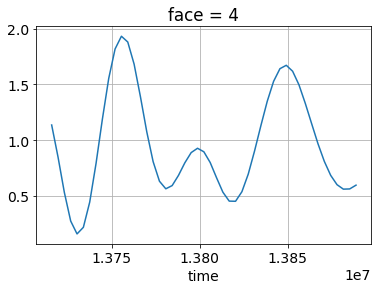

In [9]:
SSHmean_xy_2days =SSH2d_2days.mean(dim=['i','j'])
SSHmean_xy_2days.plot()
plt.grid()

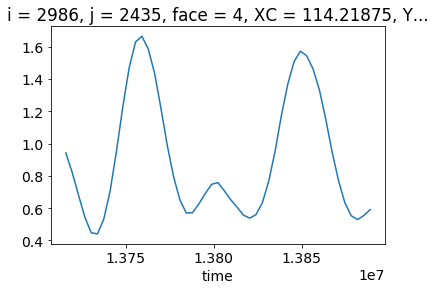

In [10]:
## select one pixel
SSH_t=SSH2d_2days.sel(i=2986,j=2435)
SSH_t.plot()

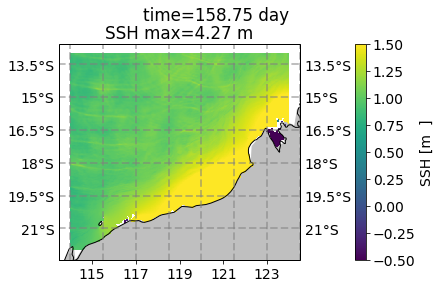

In [25]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(SSH2d_2days.XC,SSH2d_2days.YC,SSH2d_2days[t0,:,:], \
                transform = ccrs.PlateCarree(),vmin=-0.5,vmax=1.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SSH [m  ]')
ax.set_title(r'SSH max=%.2f m' %(np.abs(SSH2d_2days[t0,:,:]).max(skipna=True) ))
thour=(SSH2d_2days.time[t0]/3600)
tday=(SSH2d_2days.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Eta_'+str(int(thour.values))+'.png'
frame = graphdir+'movies/Eta/'+figname
fig.savefig(frame, dpi=150)

In [24]:
if(Frame):
    Nt=SSH2d_2days.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(SSH2d_2days.XC,SSH2d_2days.YC,SSH2d_2days[t0,:,:], \
                        transform = ccrs.PlateCarree(),vmin=-0.5,vmax=1.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'SSH [m  ]')
        ax.set_title(r'SSH max=%.2f m' %(np.abs(SSH2d_2days[t0,:,:]).max(skipna=True) ))
        thour=(SSH2d_2days.time[t0]/3600)
        tday=(SSH2d_2days.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='Eta_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/Eta/'+figname
        fig.savefig(frame, dpi=150)

        plt.close(fig)